In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [4]:
np.random.seed(42)

In [8]:
# Load the dataset
df = pd.read_csv('stocks_data.csv')
# Microsoft data
msft_data = df[df['symbol'] == 'MSFT']
close_prices = msft_data.reset_index()['close']

In [10]:
# Scaling the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(close_prices).reshape(-1, 1))

In [12]:
# Using 80% of data for training, 20% for testing
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :1]

In [14]:
# Creating dataset with time steps and sequence features
def create_dataset(dataset, time_step=1):
    """
    Convert an array of values into a dataset matrix for linear regression.
    
    Args:
        dataset: Array of values
        time_step: Number of previous time steps to use as input features
        
    Returns:
        X: Training features with shape (n_samples, time_step)
        y: Target values
    """
    X, y = [], []
    for i in range(len(dataset) - time_step):
        # Extracting 'time_step' number of previous values as features
        X.append(dataset[i:i + time_step, 0])
        # The next value becomes the target
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)


In [16]:
# Creating datasets with different lookback periods to test
lookback_periods = [5, 10, 20, 40, 60, 80]
best_test_rmse = float('inf')
best_lookback = None
results = []

In [18]:
# Creating datasets with different lookback periods to test
lookback_periods = [5, 10, 20, 40, 60, 80]
best_test_rmse = float('inf')
best_lookback = None
results = []

for time_step in lookback_periods:
    #training and testing datasets
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    #Training
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    train_predictions = model.predict(X_train).reshape(-1, 1)
    test_predictions = model.predict(X_test).reshape(-1, 1)
    
    # Inverse transform to get actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    
    # Scale back the y values for comparison
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    #performance metrics
    train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predictions))
    test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predictions))
    train_mape = mean_absolute_percentage_error(y_train_actual, train_predictions) * 100
    test_mape = mean_absolute_percentage_error(y_test_actual, test_predictions) * 100
    
    # Store results
    results.append({
        'Lookback': time_step,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    })
    
    # Track best model
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        best_lookback = time_step
        best_model = model
        best_X_train = X_train
        best_X_test = X_test
        best_y_train = y_train_actual
        best_y_test = y_test_actual
        best_train_pred = train_predictions
        best_test_pred = test_predictions

# Display results table
results_df = pd.DataFrame(results)

In [20]:
print("Model Performance with Different Lookback Periods:")
print(results_df)
print(f"\nBest Lookback Period: {best_lookback} days with Test RMSE: {best_test_rmse:.2f}")


Model Performance with Different Lookback Periods:
   Lookback  Train RMSE  Test RMSE  Train MAPE  Test MAPE
0         5    4.906530   5.492331    1.026421   0.921961
1        10    4.890822   5.583793    1.022022   0.932526
2        20    4.753677   5.658122    0.984261   0.915165
3        40    4.654217   6.347524    0.958400   1.103576
4        60    4.507920   5.516968    0.905116   0.995588
5        80    4.201278   4.338245    0.849477   0.973176

Best Lookback Period: 80 days with Test RMSE: 4.34


In [22]:
# Using the best model for prediction visualization
time_step = best_lookback

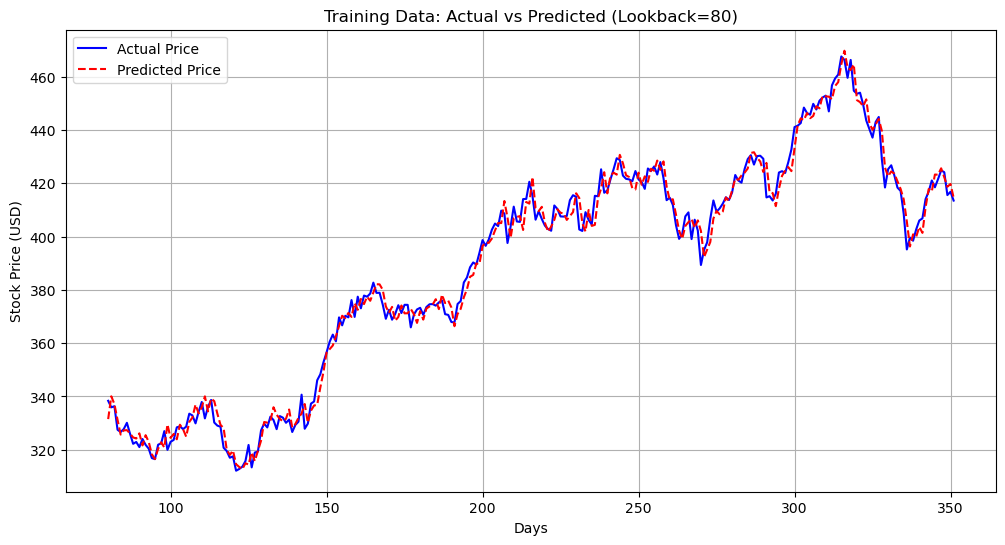

In [26]:
# Visualize training predictions
plt.figure(figsize=(12, 6))
plt.title(f'Training Data: Actual vs Predicted (Lookback={time_step})')
train_time = np.arange(time_step, len(train_data))
plt.plot(train_time, best_y_train, 'b', label='Actual Price')
plt.plot(train_time, best_train_pred, 'r--', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

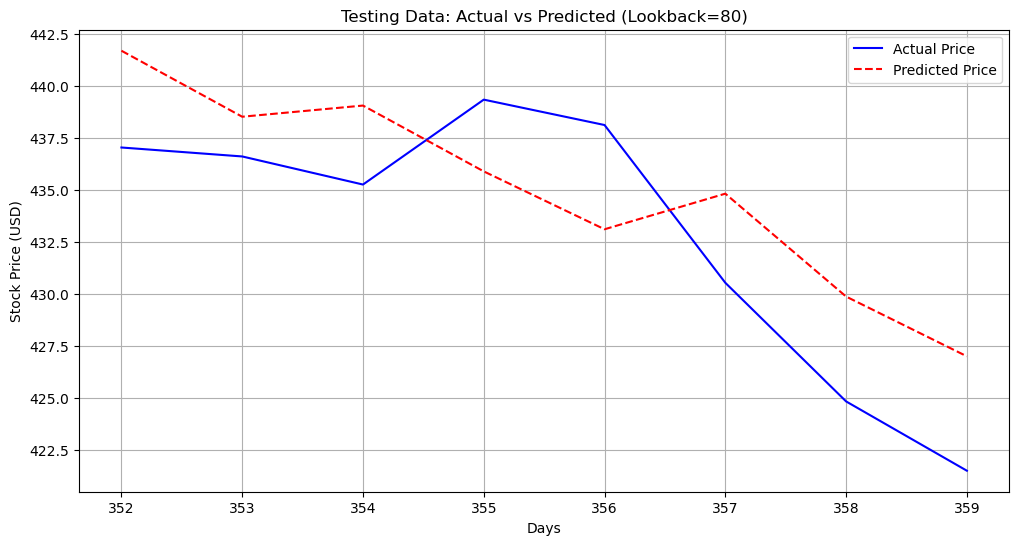

In [28]:
# Visualize testing predictions
plt.figure(figsize=(12, 6))
plt.title(f'Testing Data: Actual vs Predicted (Lookback={time_step})')
test_time = np.arange(train_size, train_size + len(best_test_pred))
plt.plot(test_time, best_y_test, 'b', label='Actual Price')
plt.plot(test_time, best_test_pred, 'r--', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Future predictions with the best model
def predict_future_linear(model, last_sequence, n_steps, n_days=20):
    """
    Predict future values using a trained linear regression model.
    
    Args:
        model: Trained linear regression model
        last_sequence: Last sequence of known values
        n_steps: Lookback period used in training
        n_days: Number of days to predict into future
        
    Returns:
        Array of predicted values
    """
    future_predictions = []
    
    if isinstance(last_sequence, np.ndarray):
        input_sequence = last_sequence.flatten().tolist()
    else:
        input_sequence = list(last_sequence)
    
    # Copy to avoid modifying the original
    current_sequence = input_sequence.copy()
    
    # Predict n_days into the future
    for _ in range(n_days):
        # Take the last n_steps elements
        if len(current_sequence) > n_steps:
            x_input = np.array(current_sequence[-n_steps:])
        else:
            x_input = np.array(current_sequence)
            
        # Reshape for prediction
        x_input = x_input.reshape(1, -1)
        
        # Make prediction (next day)
        next_day_price = model.predict(x_input)
        
        # Append prediction to our sequence
        current_sequence.append(next_day_price[0])
        future_predictions.append(next_day_price[0])
    
    return np.array(future_predictions).reshape(-1, 1)

In [32]:
# Getting the last known sequence
last_known_sequence = test_data.flatten()[-time_step:]

# Predicting next 20 days
future_days = 20
future_predictions = predict_future_linear(
    best_model, 
    last_known_sequence, 
    time_step, 
    n_days=future_days
)

In [34]:
# Convert predictions back to original scale
future_predictions_actual = scaler.inverse_transform(future_predictions)


In [36]:
# Plot future predictions
last_date_idx = len(scaled_data) - 1
future_date_range = np.arange(last_date_idx + 1, last_date_idx + future_days + 1)

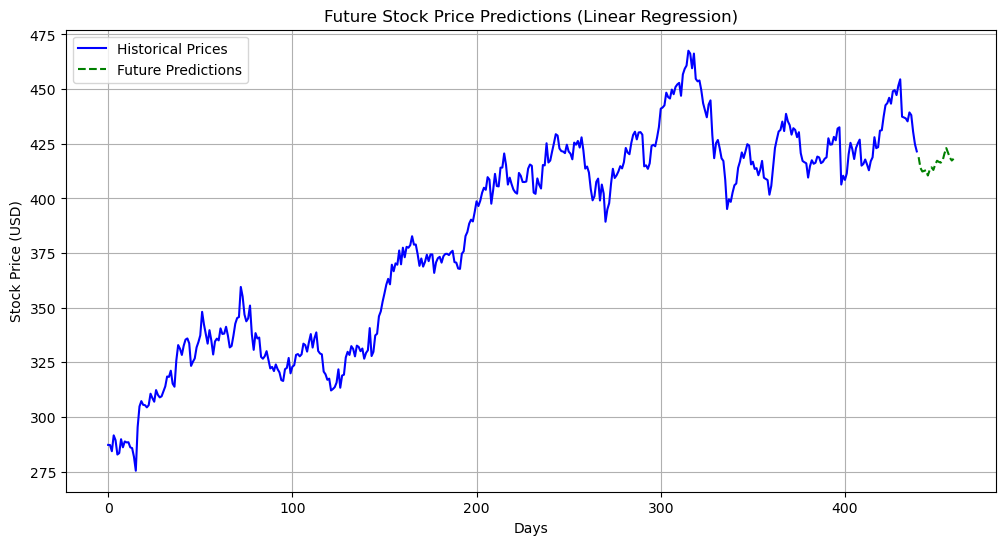

In [38]:
plt.figure(figsize=(12, 6))
plt.title('Future Stock Price Predictions (Linear Regression)')
# Known data
plt.plot(np.arange(len(close_prices)), scaler.inverse_transform(scaled_data), 'b', label='Historical Prices')
# Future predictions
plt.plot(future_date_range, future_predictions_actual, 'g--', label='Future Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

January Prediction RMSE: 15.68
January Prediction MAPE: 2.95%


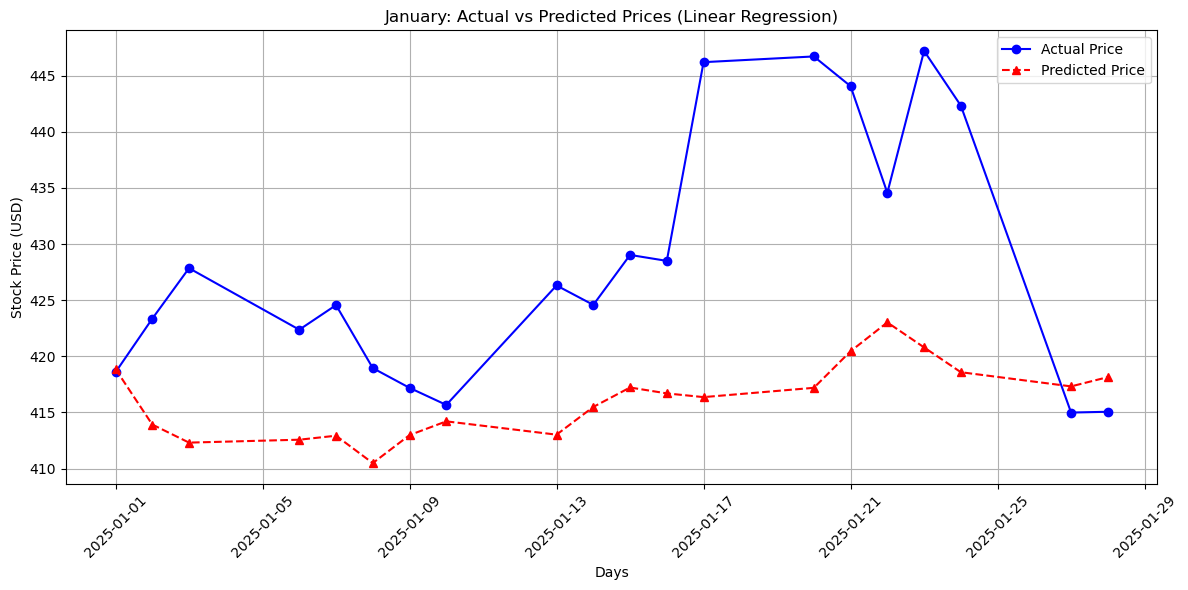

         Date  Actual   Predicted
0  2025-01-01  418.58  418.864965
1  2025-01-02  423.35  413.922050
2  2025-01-03  427.85  412.311910
3  2025-01-06  422.37  412.571342
4  2025-01-07  424.56  412.926851
5  2025-01-08  418.95  410.486050
6  2025-01-09  417.19  412.980692
7  2025-01-10  415.67  414.206696
8  2025-01-13  426.31  413.020407
9  2025-01-14  424.58  415.489472
10 2025-01-15  429.03  417.222024
11 2025-01-16  428.50  416.696164
12 2025-01-17  446.20  416.364524
13 2025-01-20  446.71  417.192967
14 2025-01-21  444.06  420.451065
15 2025-01-22  434.56  423.020797
16 2025-01-23  447.20  420.793292
17 2025-01-24  442.33  418.584007
18 2025-01-27  414.99  417.320535
19 2025-01-28  415.06  418.146424
Sharpe Ratio: -0.0308


In [40]:
# Compare with actual January data if available
try:
    jan_df = pd.read_csv('actual_jan.csv')
    jan_msft = jan_df[jan_df['symbol'] == 'MSFT']
    jan_close = jan_msft.reset_index()['close']
    
    actual_jan = jan_close[:future_days].values
    
    # Creating comparison DataFrame
    comparison_df = pd.DataFrame({
        'Date': pd.date_range(start='2025-01-01', periods=future_days, freq='B'),
        'Actual': actual_jan,
        'Predicted': future_predictions_actual.flatten()
    })
    
    # Error metrics
    jan_rmse = math.sqrt(mean_squared_error(actual_jan, future_predictions_actual))
    jan_mape = mean_absolute_percentage_error(actual_jan, future_predictions_actual.flatten()) * 100
    
    print(f'January Prediction RMSE: {jan_rmse:.2f}')
    print(f'January Prediction MAPE: {jan_mape:.2f}%')
    
    # Plot actual vs predicted January prices
    plt.figure(figsize=(12, 6))
    plt.title('January: Actual vs Predicted Prices (Linear Regression)')
    plt.plot(comparison_df['Date'], comparison_df['Actual'], 'b-o', label='Actual Price')
    plt.plot(comparison_df['Date'], comparison_df['Predicted'], 'r--^', label='Predicted Price')
    plt.xlabel('Days')
    plt.ylabel('Stock Price (USD)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print(comparison_df)
    
    # Calculate Sharpe Ratio
    comparison_df["Predicted_Return"] = comparison_df["Predicted"].pct_change()
    risk_free_rate = 0.02 / 252  # 2% Annual risk-free rate, 252 trading days
    comparison_df["Excess_Return"] = comparison_df["Predicted_Return"] - risk_free_rate
    mean_excess_return = comparison_df["Excess_Return"].mean()
    std_excess_return = comparison_df["Excess_Return"].std()
    sharpe_ratio = mean_excess_return / std_excess_return
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    
    # Save results
    comparison_df.to_csv('LinearRegression_Results.csv')
    
except Exception as e:
    print(f"Could not load January data for comparison: {e}")
    print("Skipping January comparison section.")